# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [3]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-da7g2g14/granite-tsfm_52fc86e255bd445aa24646773285f7ee
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-da7g2g14/granite-tsfm_52fc86e255bd445aa24646773285f7ee
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "Datasets/TSB-AD-M/115_PSM_id_1_Facility_tr_50000_1st_129872.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [5]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "Datasets/TSB-AD-M/115_PSM_id_1_Facility_tr_50000_1st_129872.csv"
timestamp_column = None
id_columns = []

data = pd.read_csv(dataset_path).iloc[:20000]
target_columns = data.columns[:-1].tolist()

num_rows = data.shape[0]
split_config = {
    "train": [0, int(0.8 * num_rows)],
    "valid": [int(0.8 * num_rows), int(0.9 * num_rows)],
    "test": [int(0.9 * num_rows), num_rows],
}

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

## Zero-shot evaluation method

In [6]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-87540:t-128828832373632:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-87540:t-128828832373632:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-87540:t-128828832373632:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 1.2646323442459106, 'eval_runtime': 19.8721, 'eval_samples_per_second': 95.863, 'eval_steps_per_second': 95.863}
(1905, 96, 25)
(1905, 25, 8, 192)


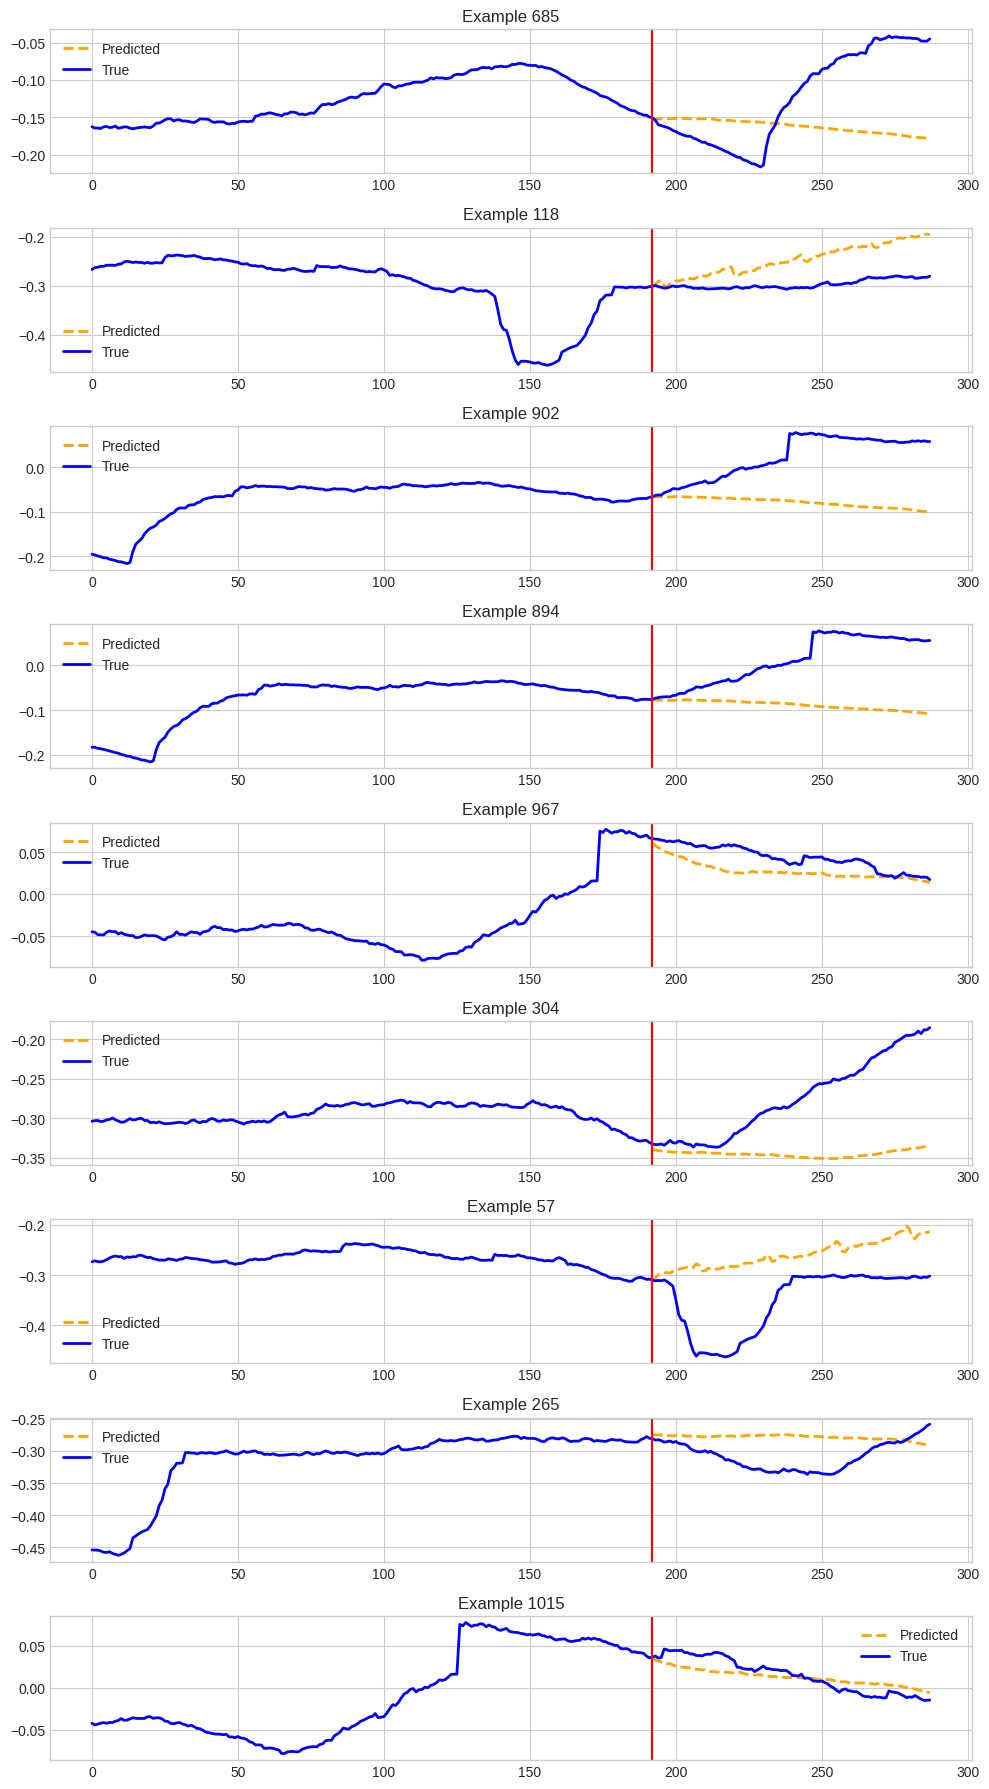

In [7]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=1
)

 ## Few-shot finetune and evaluation method

In [8]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

INFO:p-87540:t-128828832373632:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-87540:t-128828832373632:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-87540:t-128828832373632:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.492300,0.620061
2,0.439900,0.611634
3,0.395700,0.608572
4,0.360000,0.622242
5,0.327800,0.645419
6,0.312600,0.654043
7,0.296800,0.666276
8,0.288700,0.678342
9,0.280500,0.670590
10,0.272000,0.686524


[TrackingCallback] Mean Epoch Time = 18.349069888775166 seconds, Total Train Time = 297.39503383636475
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.2784429788589478, 'eval_runtime': 4.7986, 'eval_samples_per_second': 396.993, 'eval_steps_per_second': 6.252, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


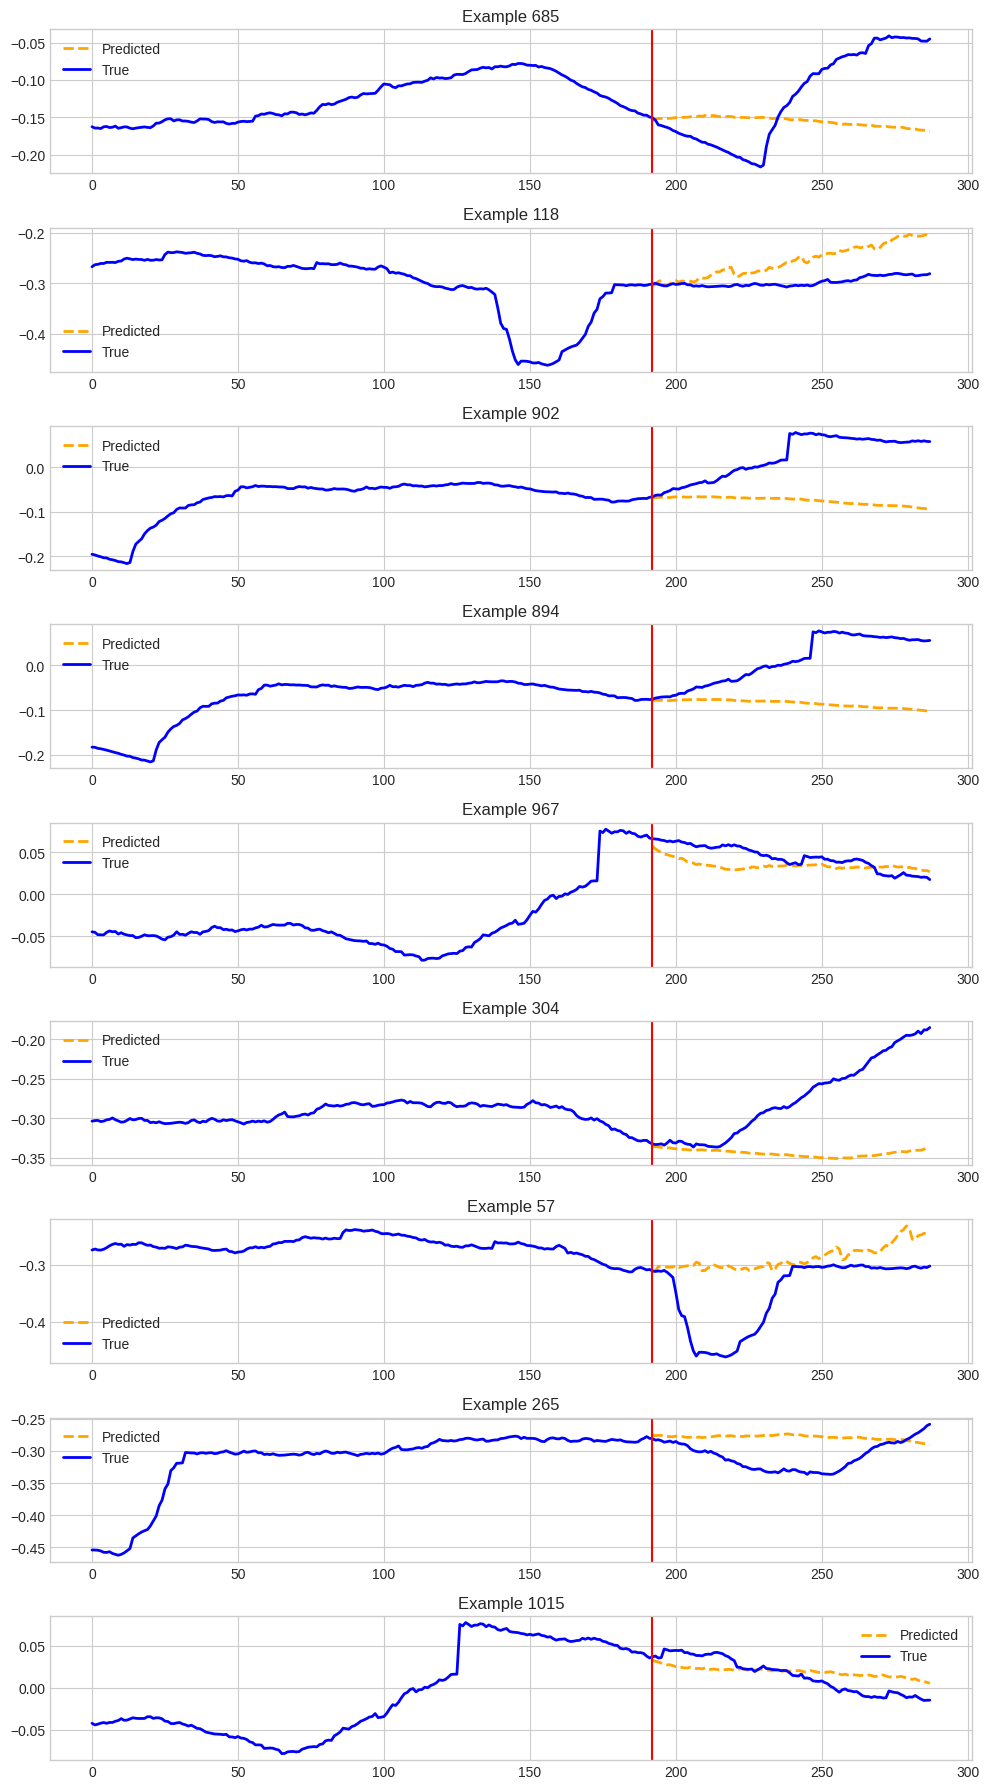

In [9]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

In [10]:
￼fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=30,
    learning_rate=0.001,
)

SyntaxError: invalid character '￼' (U+FFFC) (2018031712.py, line 1)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 50% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.452700,0.609496
2,0.381300,0.620121
3,0.363100,0.628655
4,0.350400,0.655961
5,0.343600,0.692496
6,0.338400,0.697836
7,0.334400,0.721174
8,0.331200,0.713435
9,0.329800,0.761038
10,0.328200,0.782187


[TrackingCallback] Mean Epoch Time = 6.904609636826948 seconds, Total Train Time = 95.21213054656982
++++++++++++++++++++ Test MSE after few-shot 50% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.3289949893951416, 'eval_runtime': 1.4843, 'eval_samples_per_second': 1283.425, 'eval_steps_per_second': 20.211, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


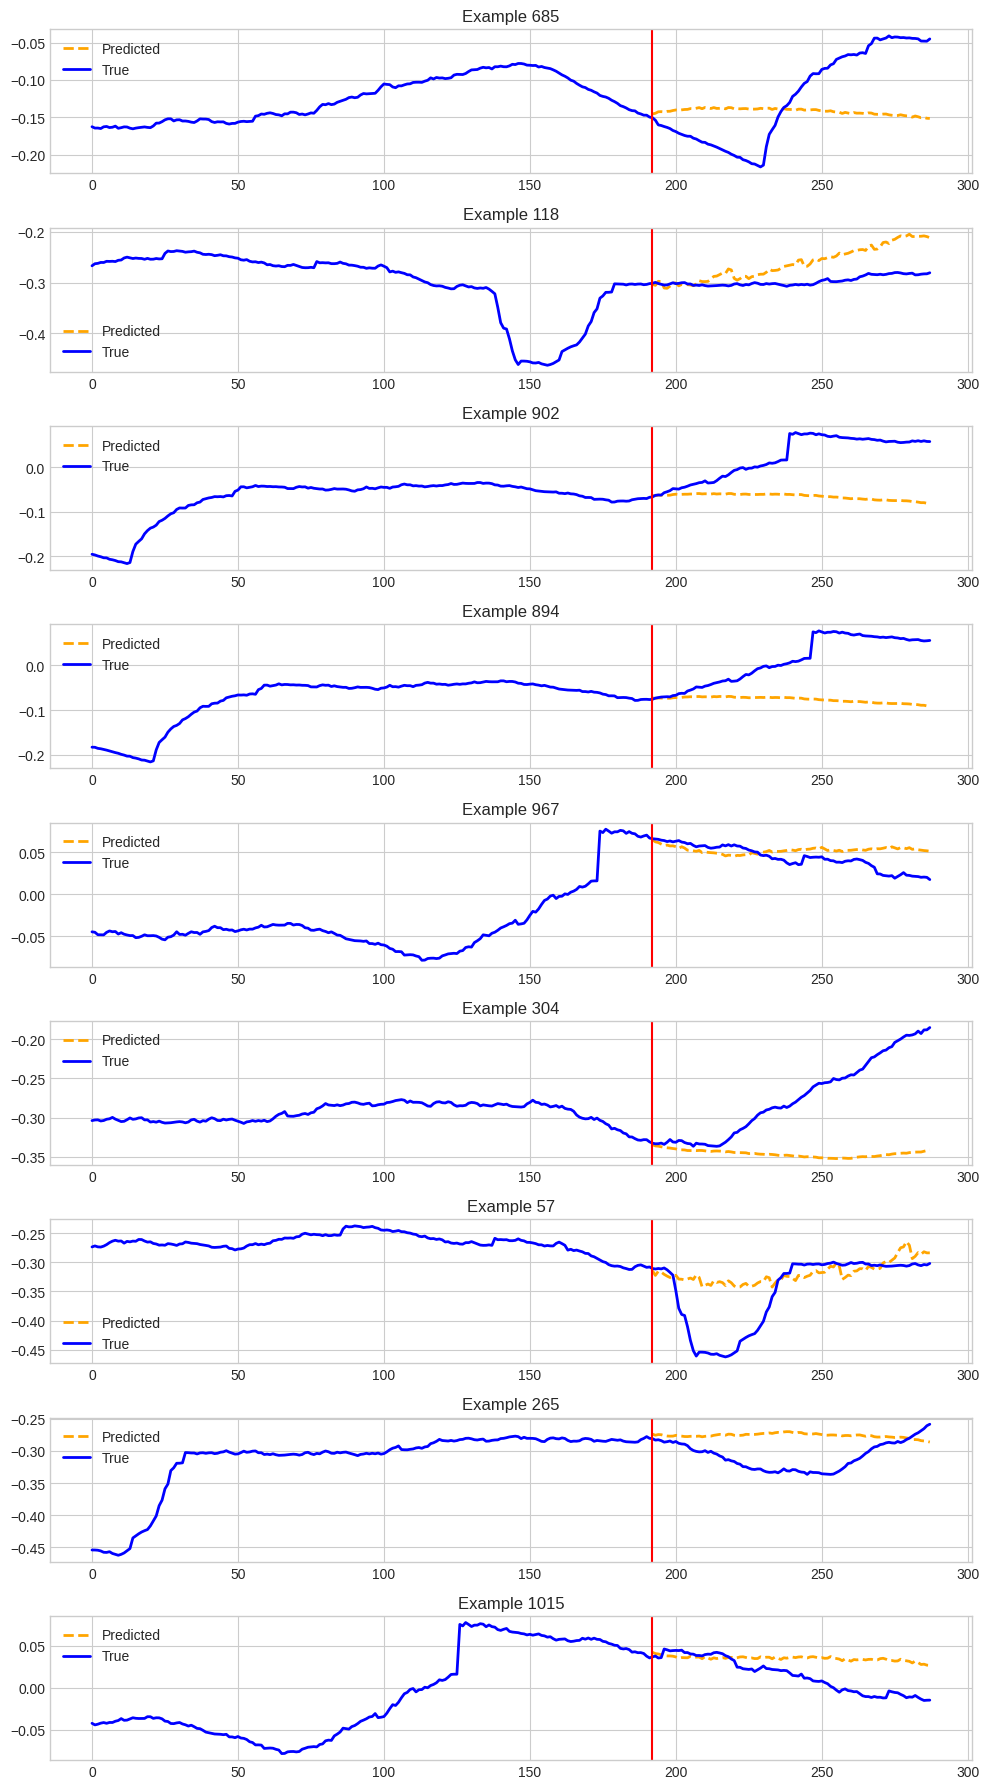

In [11]:
￼fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=50,
    learning_rate=0.001,
)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 80% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.418700,0.609050
2,0.361000,0.619162
3,0.345900,0.642235
4,0.336400,0.660495
5,0.331800,0.685116
6,0.327000,0.697630
7,0.324300,0.734333
8,0.322600,0.738613
9,0.321000,0.700838
10,0.320400,0.701532


[TrackingCallback] Mean Epoch Time = 11.300243074243719 seconds, Total Train Time = 144.22095155715942
++++++++++++++++++++ Test MSE after few-shot 80% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.334276556968689, 'eval_runtime': 1.5664, 'eval_samples_per_second': 1216.197, 'eval_steps_per_second': 19.153, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


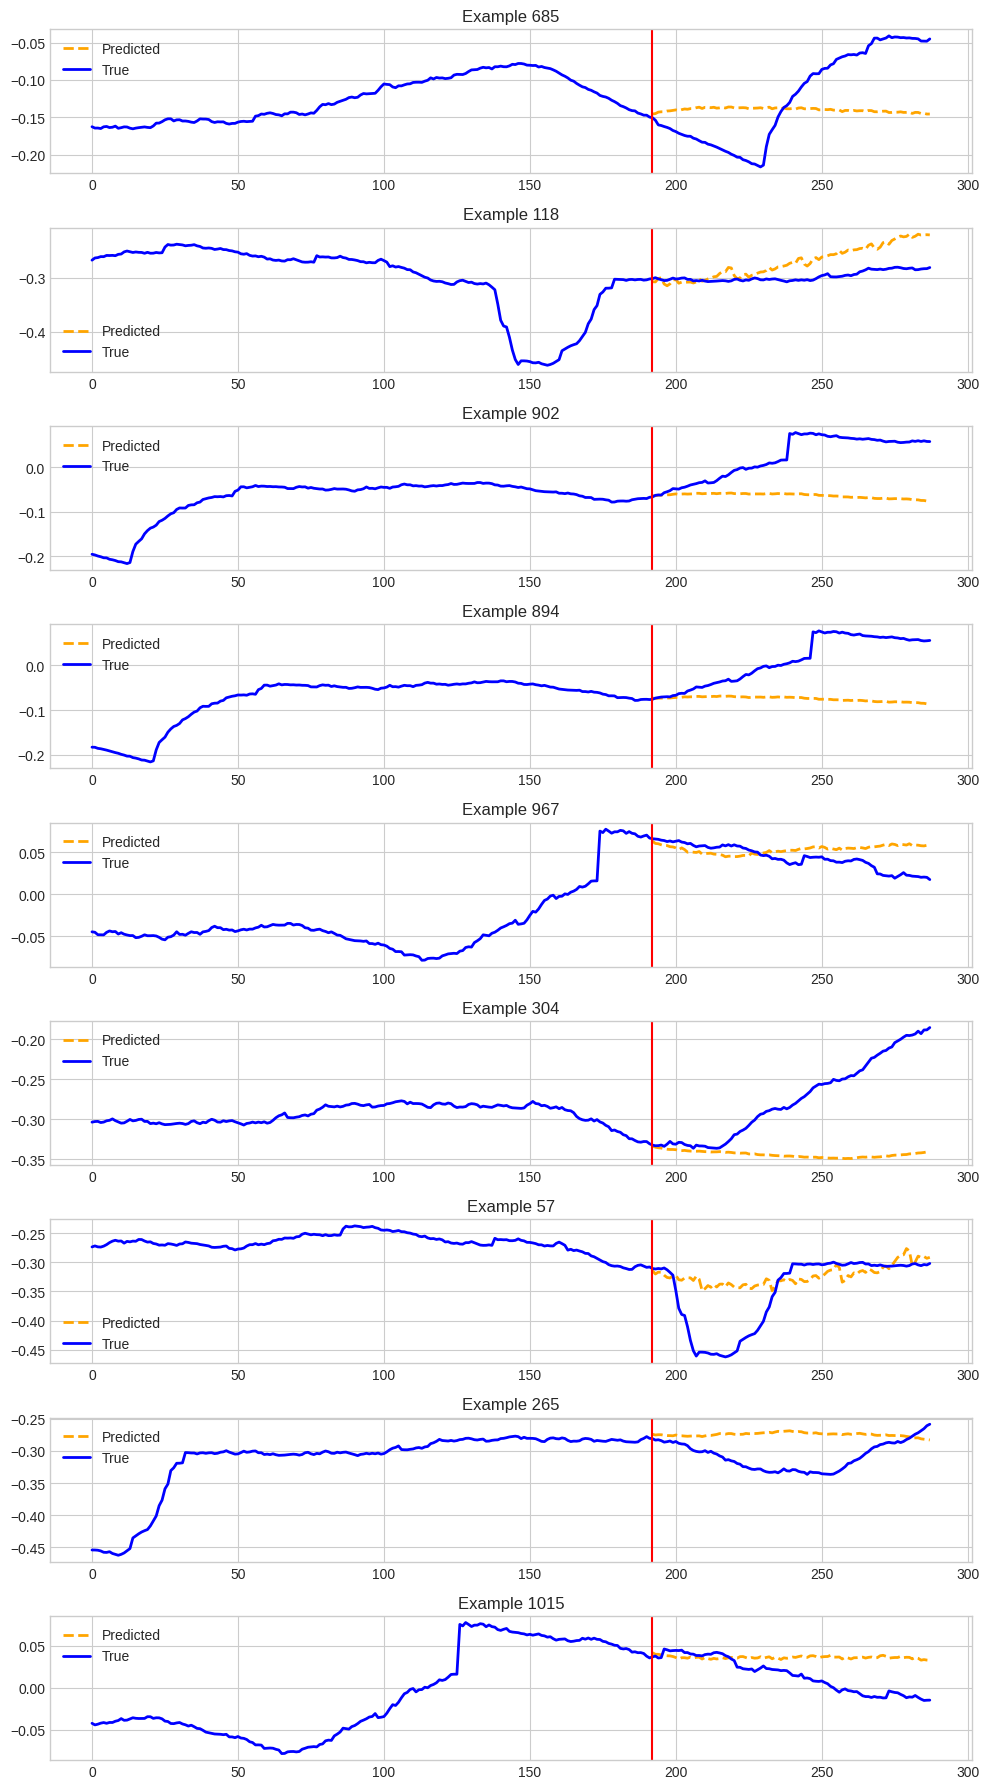

In [12]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=80,
    learning_rate=0.001,
)

In [13]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=False,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.485100,0.622943
2,0.414500,0.630534
3,0.360400,0.666843
4,0.312700,0.689577
5,0.290800,0.753174
6,0.267700,0.791784
7,0.252100,0.796506
8,0.241500,0.833050
9,0.229000,0.843816
10,0.219200,0.885340


[TrackingCallback] Mean Epoch Time = 1.75598575852134 seconds, Total Train Time = 38.51347327232361
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.2610074281692505, 'eval_runtime': 1.4863, 'eval_samples_per_second': 1281.705, 'eval_steps_per_second': 20.184, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


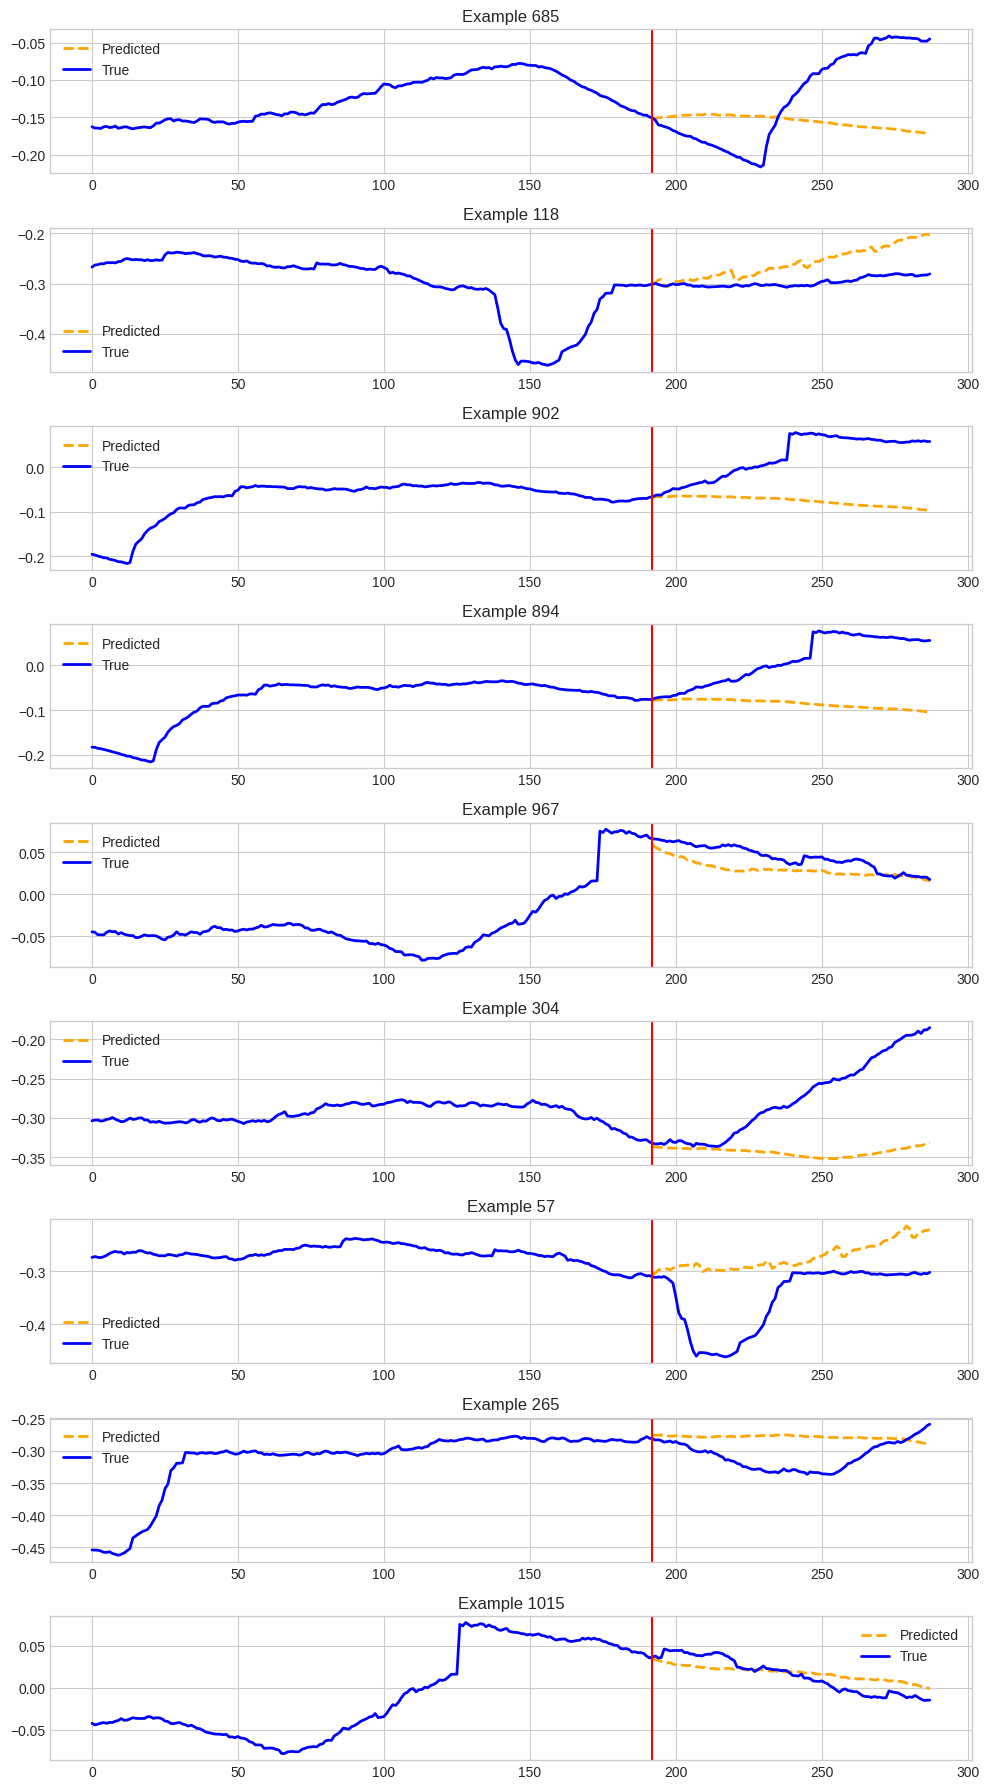

In [14]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 30% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.427200,0.673811
2,0.347900,0.730282
3,0.326000,0.766921
4,0.315200,0.795246
5,0.307700,0.808742
6,0.302300,0.798060
7,0.293000,0.840718
8,0.284000,0.849044
9,0.276100,0.842760
10,0.267500,0.840846


[TrackingCallback] Mean Epoch Time = 7.331434574994174 seconds, Total Train Time = 101.18892550468445
++++++++++++++++++++ Test MSE after few-shot 30% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.3763494491577148, 'eval_runtime': 1.5286, 'eval_samples_per_second': 1246.274, 'eval_steps_per_second': 19.626, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


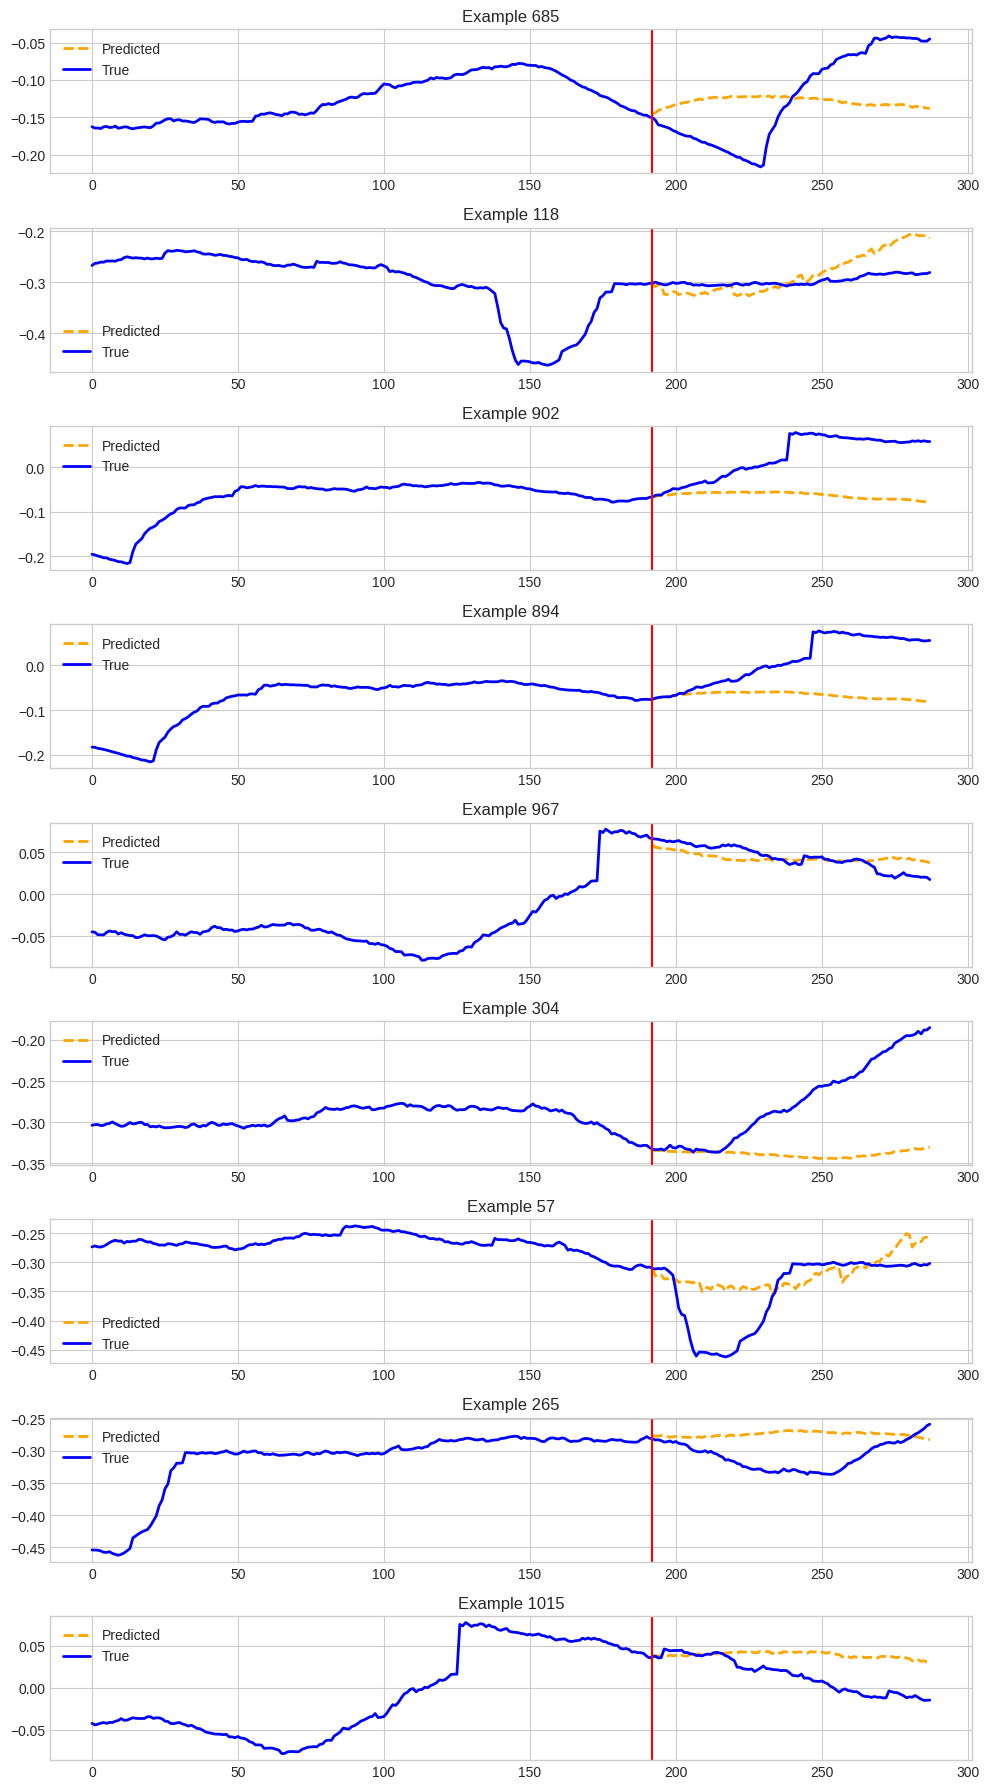

In [15]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=30,
    learning_rate=0.001,
)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 50% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.417300,0.699910
2,0.353500,0.719666
3,0.339400,0.731880
4,0.330600,0.766888
5,0.323600,0.785125
6,0.315100,0.802675
7,0.306800,0.910539
8,0.298200,0.784532
9,0.291100,0.819571
10,0.284300,0.837553


[TrackingCallback] Mean Epoch Time = 11.60418701171875 seconds, Total Train Time = 147.62666726112366
++++++++++++++++++++ Test MSE after few-shot 50% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.4180757999420166, 'eval_runtime': 1.6157, 'eval_samples_per_second': 1179.039, 'eval_steps_per_second': 18.568, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


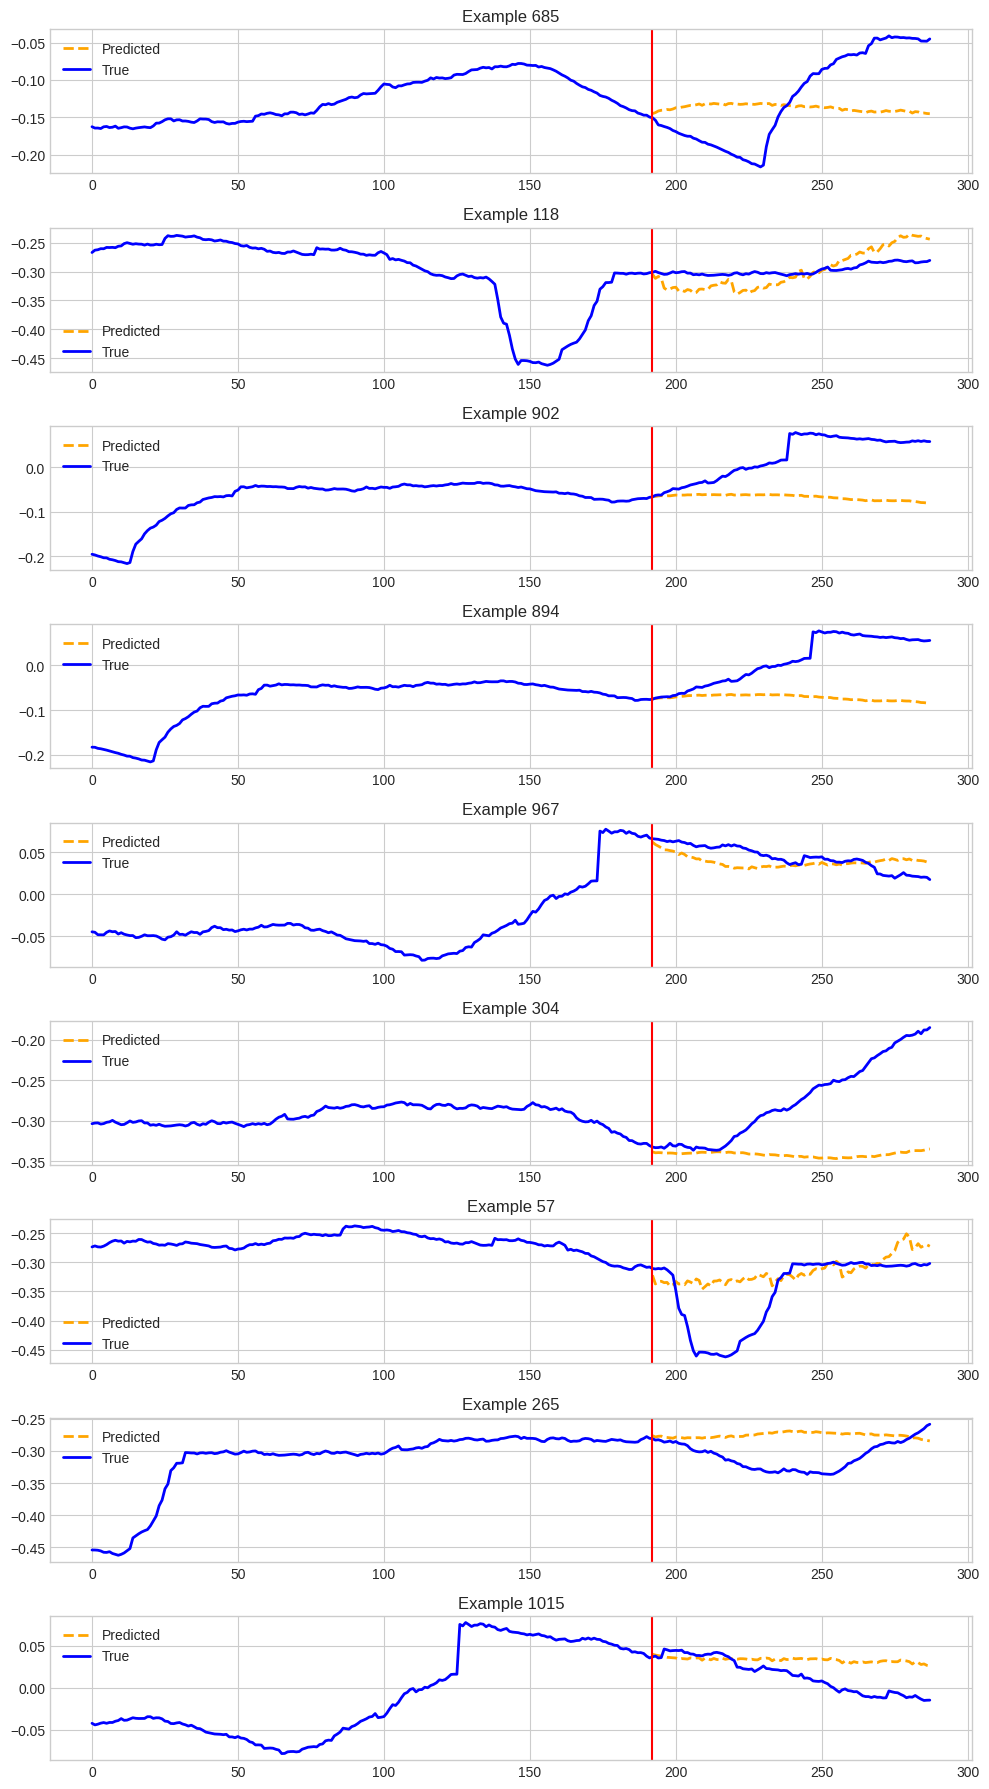

In [16]:
￼fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=50,
    learning_rate=0.001,
)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 80% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.387900,0.689635
2,0.338500,0.707445
3,0.327300,0.720146
4,0.319300,0.711008
5,0.313900,0.688722
6,0.307200,0.719189
7,0.299900,0.729514
8,0.293000,0.757272
9,0.286000,0.735396
10,0.281000,0.786269


[TrackingCallback] Mean Epoch Time = 18.144693740208943 seconds, Total Train Time = 298.5418336391449
++++++++++++++++++++ Test MSE after few-shot 80% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.4366307258605957, 'eval_runtime': 1.7828, 'eval_samples_per_second': 1068.536, 'eval_steps_per_second': 16.827, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


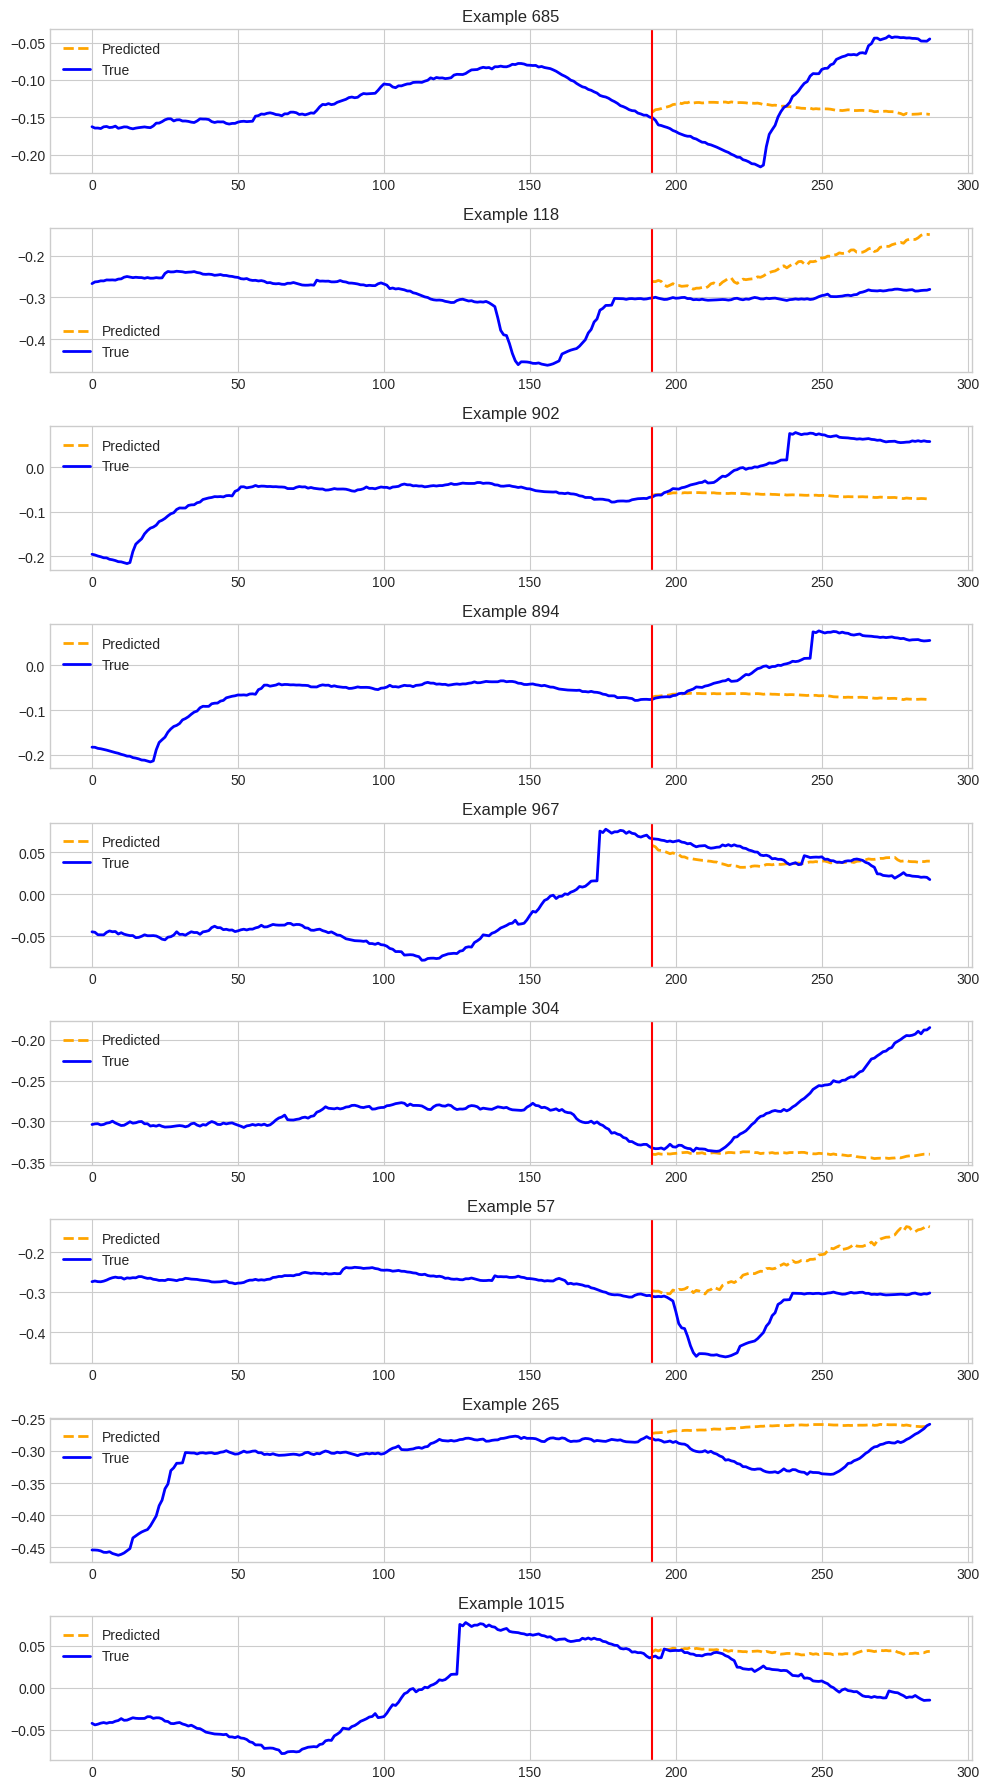

In [17]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=80,
    learning_rate=0.001,
)

￼# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.227400,0.239547
2,0.206700,0.237984
3,0.193700,0.239421
4,0.183700,0.243952
5,0.178100,0.247606
6,0.173100,0.249400
7,0.168300,0.252856
8,0.165000,0.256135
9,0.161000,0.256688
10,0.157900,0.262821


[TrackingCallback] Mean Epoch Time = 1.734171470006307 seconds, Total Train Time = 42.50658082962036
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.3405535221099854, 'eval_runtime': 1.7024, 'eval_samples_per_second': 1119.008, 'eval_steps_per_second': 17.622, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


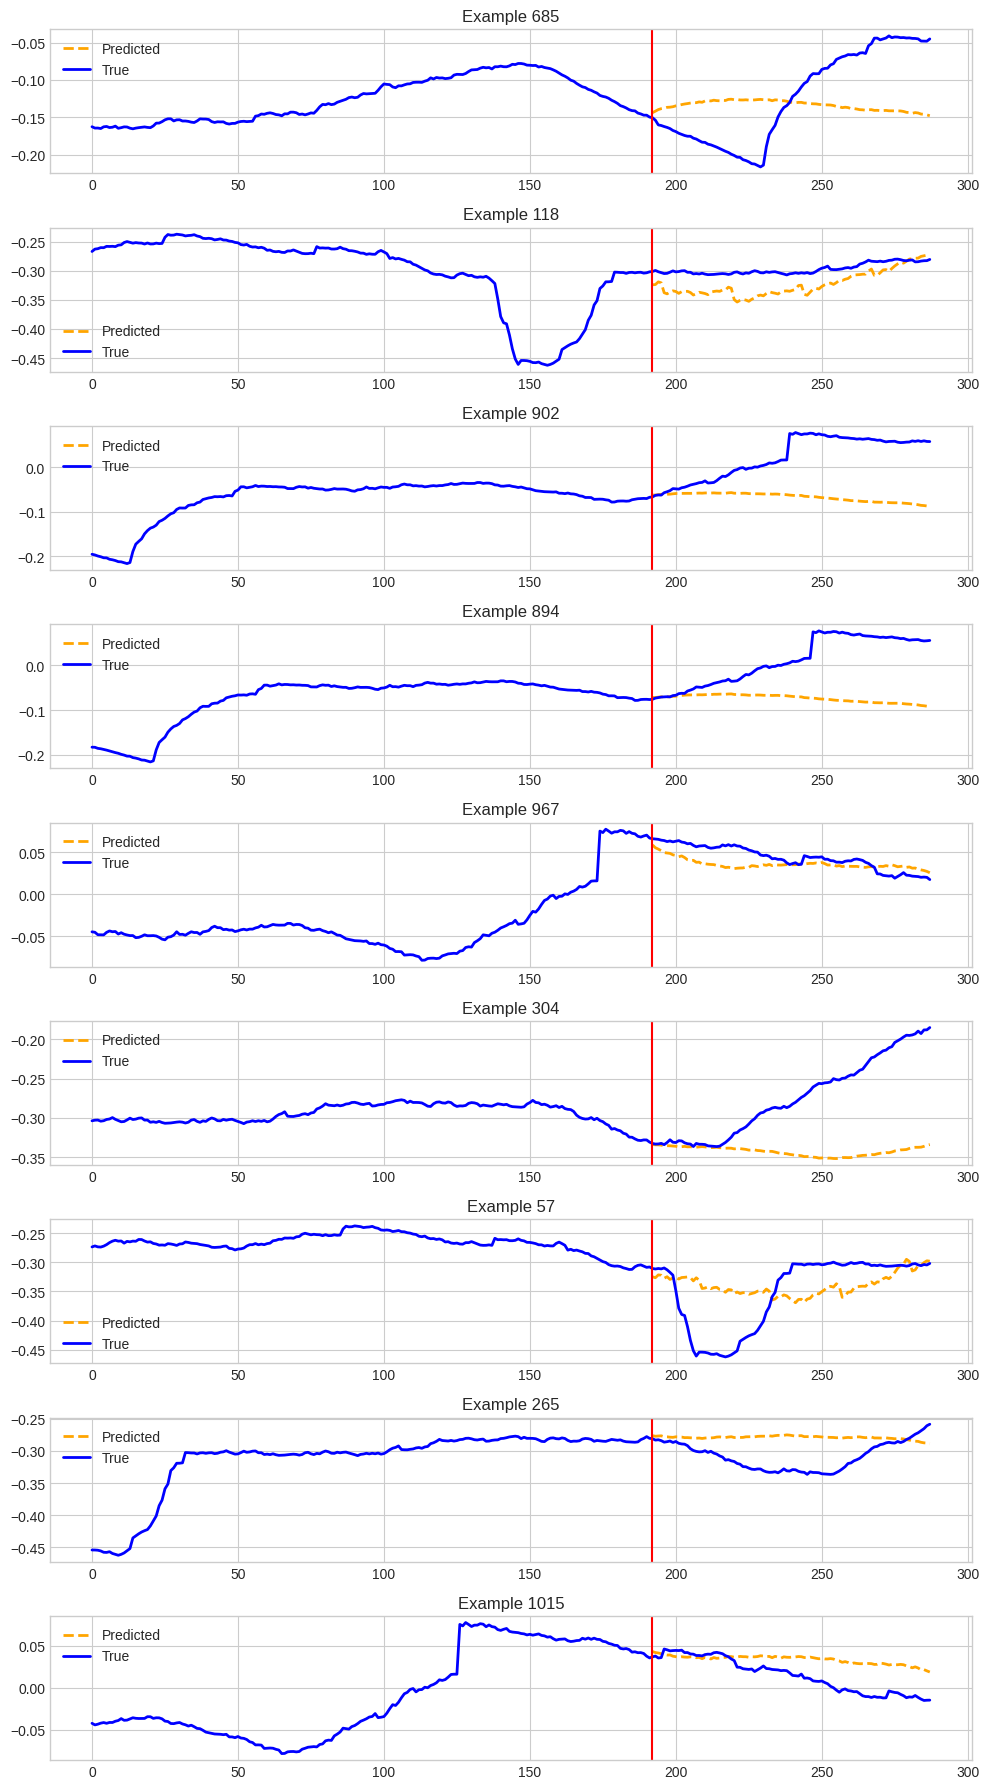

In [18]:
￼fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

￼## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.8318035006523132, 'eval_runtime': 3.789, 'eval_samples_per_second': 515.436, 'eval_steps_per_second': 8.182}
(1953, 48, 25)
(1953, 25, 8, 384)


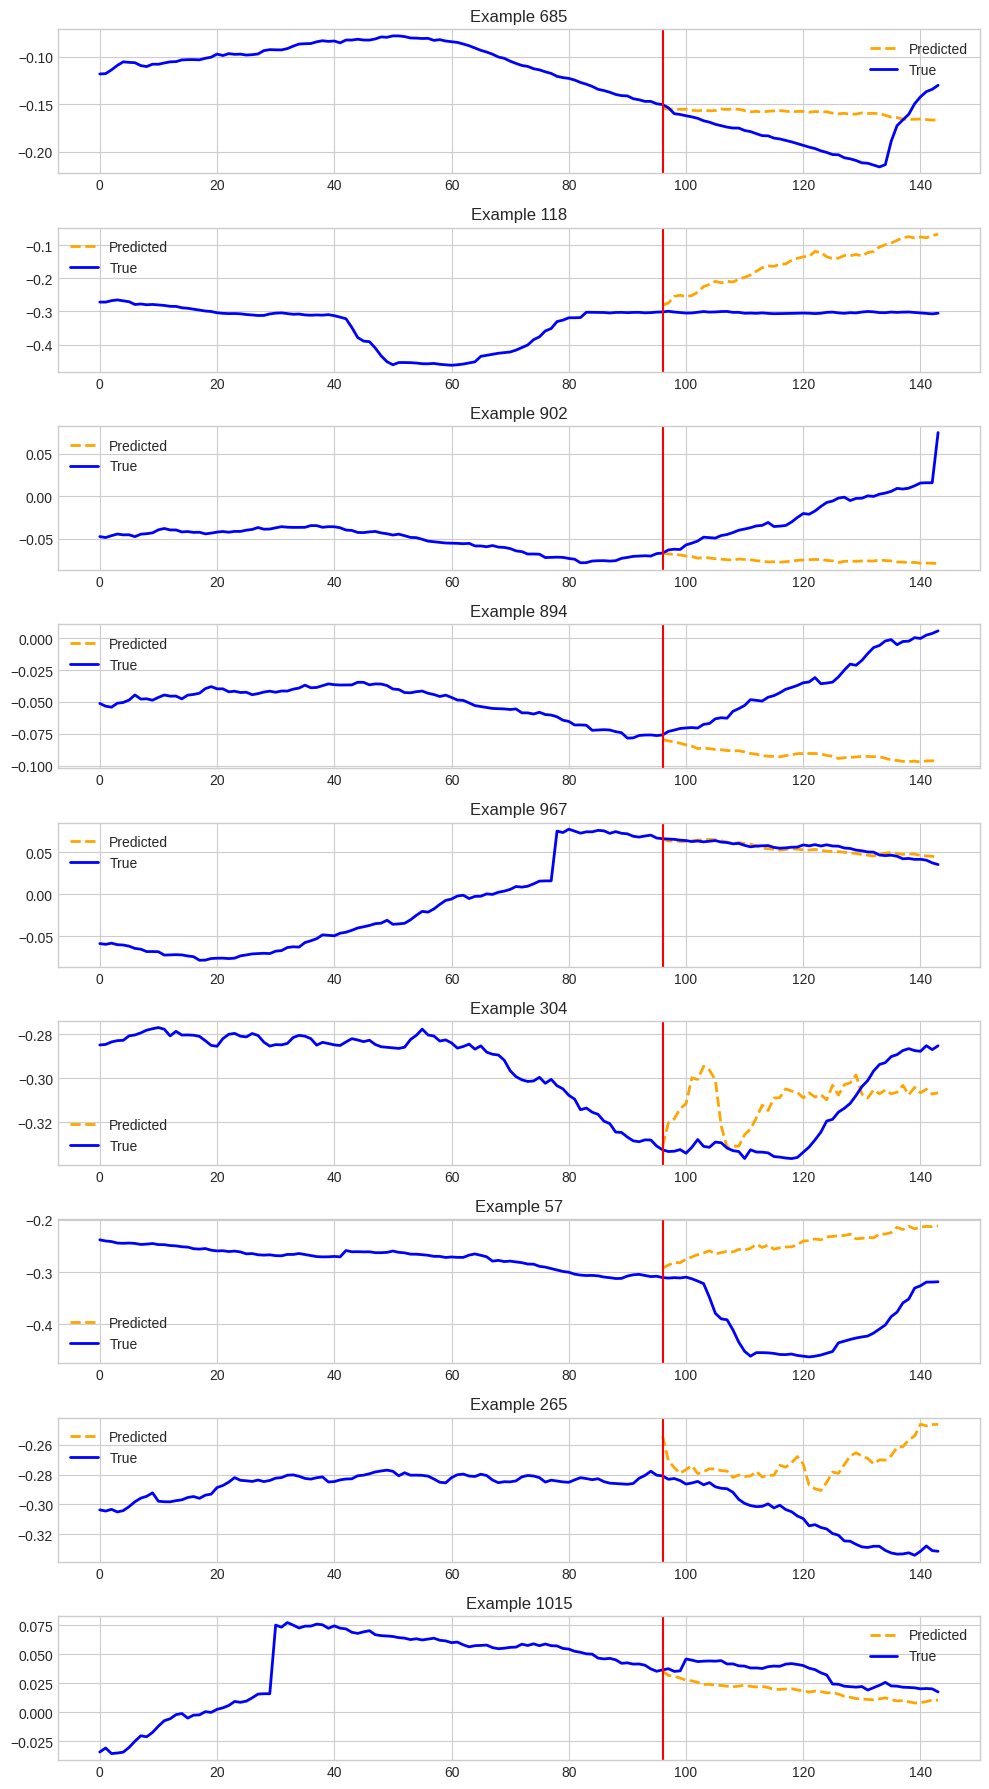

In [19]:
backbonezeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-60271:t-136831203257216:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-60271:t-136831203257216:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-60271:t-136831203257216:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96
INFO:p-60271:t-136831203257216:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-60271:t-136831203257216:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
INFO:p-60271:t-136831203257216:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 9.770099572992256e-05


OPTIMAL SUGGESTED LEARNING RATE = 9.770099572992256e-05
Using learning rate = 9.770099572992256e-05


Epoch,Training Loss,Validation Loss
1,0.593100,0.424967
2,0.523400,0.422318
3,0.441700,0.419114
4,0.377500,0.417140
5,0.325400,0.417014
6,0.288300,0.418896
7,0.265400,0.422940
8,0.250100,0.426657
9,0.239100,0.429366
10,0.231800,0.429273


Checkpoint destination directory ttm_finetuned_models/etth1/output/checkpoint-22 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[TrackingCallback] Mean Epoch Time = 4.09715477625529 seconds, Total Train Time = 121.30763602256775
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.8493884205818176, 'eval_runtime': 3.9938, 'eval_samples_per_second': 489.014, 'eval_steps_per_second': 7.762, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1953, 48, 25)
(1953, 25, 12, 384)


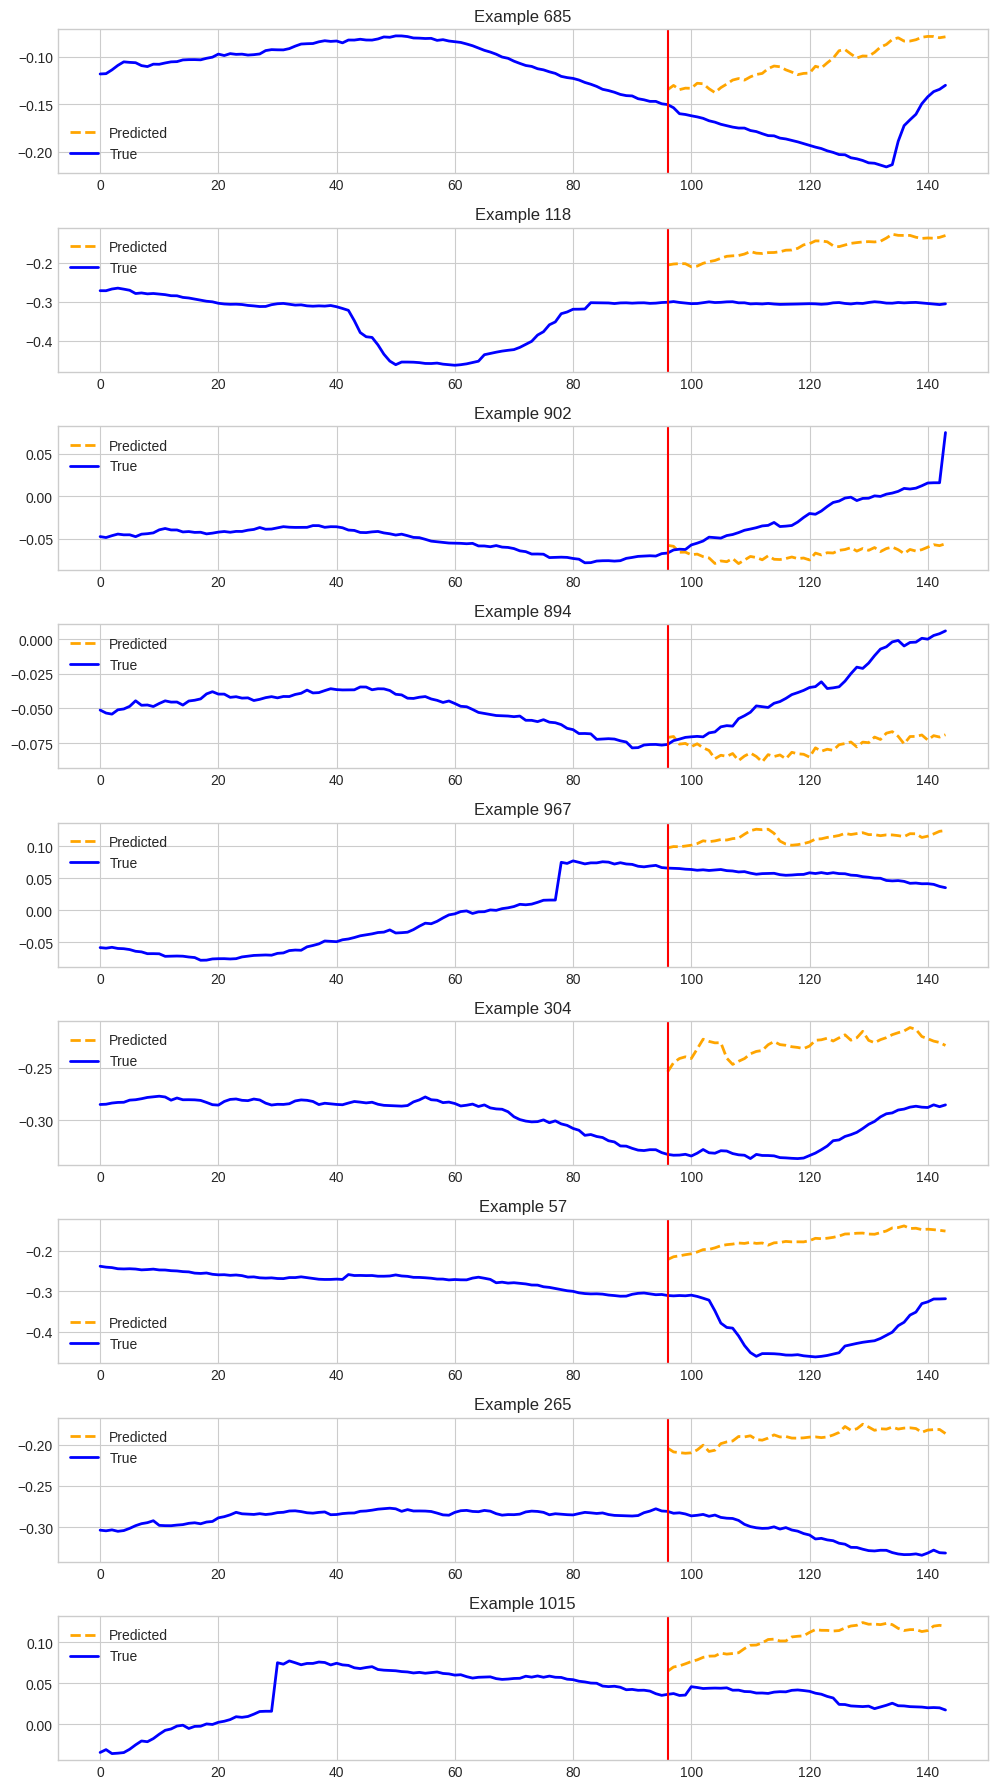

In [20]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)

In [22]:
labels = data.iloc[:, -1].values

In [33]:
import numpy as np
raw_scores = np.mean(np.abs(preds - targets), axis=(1, 2))  # shape: (n_predictions,)

NameError: name 'preds' is not defined

In [ ]:
padded_scores = np.zeros_like(labels, dtype=float)
padding = len(labels) - len(raw_scores)
padded_scores[padding:] = raw_scores

In [ ]:
import matplotlib.pyplot as plt

channel = 0  # feature index to visualize
actuals = data.iloc[:, channel].values

plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual values')
plt.scatter(np.where(labels == 1), actuals[labels == 1], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.title('Anomalies in Actual Time Series')
plt.show()